In [423]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import os
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from pykalman import KalmanFilter
from statistics import mean
from tqdm import tqdm
from matplotlib.legend_handler import HandlerTuple

In [424]:
data=pd.read_csv("time_series_data_human_activities.csv")
data.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


In [425]:
df=pd.read_csv("df_state20_iter5.csv")
df.head()

/var/folders/x3/lvyg3rhj34dgz16q_h6kfpb80000gn/T/ipykernel_16186/2446278559.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("df_state20_iter5.csv")


,Downstairs1,Downstairs3,Downstairs4,Downstairs5,Downstairs6,Downstairs7,Downstairs8,Downstairs10,Downstairs11,Downstairs12,...,Walking27,Walking28,Walking29,Walking30,Walking31,Walking32,Walking33,Walking34,Walking35,Walking36
0,0.804948,3.229267,2.005982,-0.163803,-1.102187,6.604542,3.097861,1.021607,3.806241,-0.893517,...,2.330584,-1.113011,3.332306,10.040906,-0.243055,-0.588669,-0.10467,0.998754,2.397836,0.967302
1,-0.050121,2.598322,1.690302,-0.516009,0.167512,4.176169,3.8221,1.230275,2.703777,0.323506,...,1.624417,-1.279621,1.302727,6.621482,-0.247935,0.69528,-0.038308,1.649472,0.345556,0.390018
2,-0.544826,-0.116732,-1.002712,-1.126653,-0.034973,1.001103,1.730294,0.279167,-0.768788,-0.194938,...,0.051597,1.220963,0.112366,0.008185,0.013573,-0.056509,0.001469,0.149579,-0.006982,0.012518
3,1.220427,0.220706,-0.934795,-0.188999,0.352619,0.016902,-0.512861,-0.043692,0.390008,0.273119,...,0.101637,0.878927,-0.020404,0.086424,0.620088,-0.15633,-0.021002,0.119907,0.171783,-0.007444
4,1.044444,-0.484877,-0.067851,0.452527,1.257142,1.090998,0.436504,0.047963,0.990787,0.297475,...,-0.028206,1.865033,-0.061064,0.470879,0.868354,0.241434,-0.012959,0.051644,0.113606,0.005091


In [427]:
label=df.to_numpy()[-1]
dp=df.to_numpy()[:-1]

In [428]:
len(label)

179

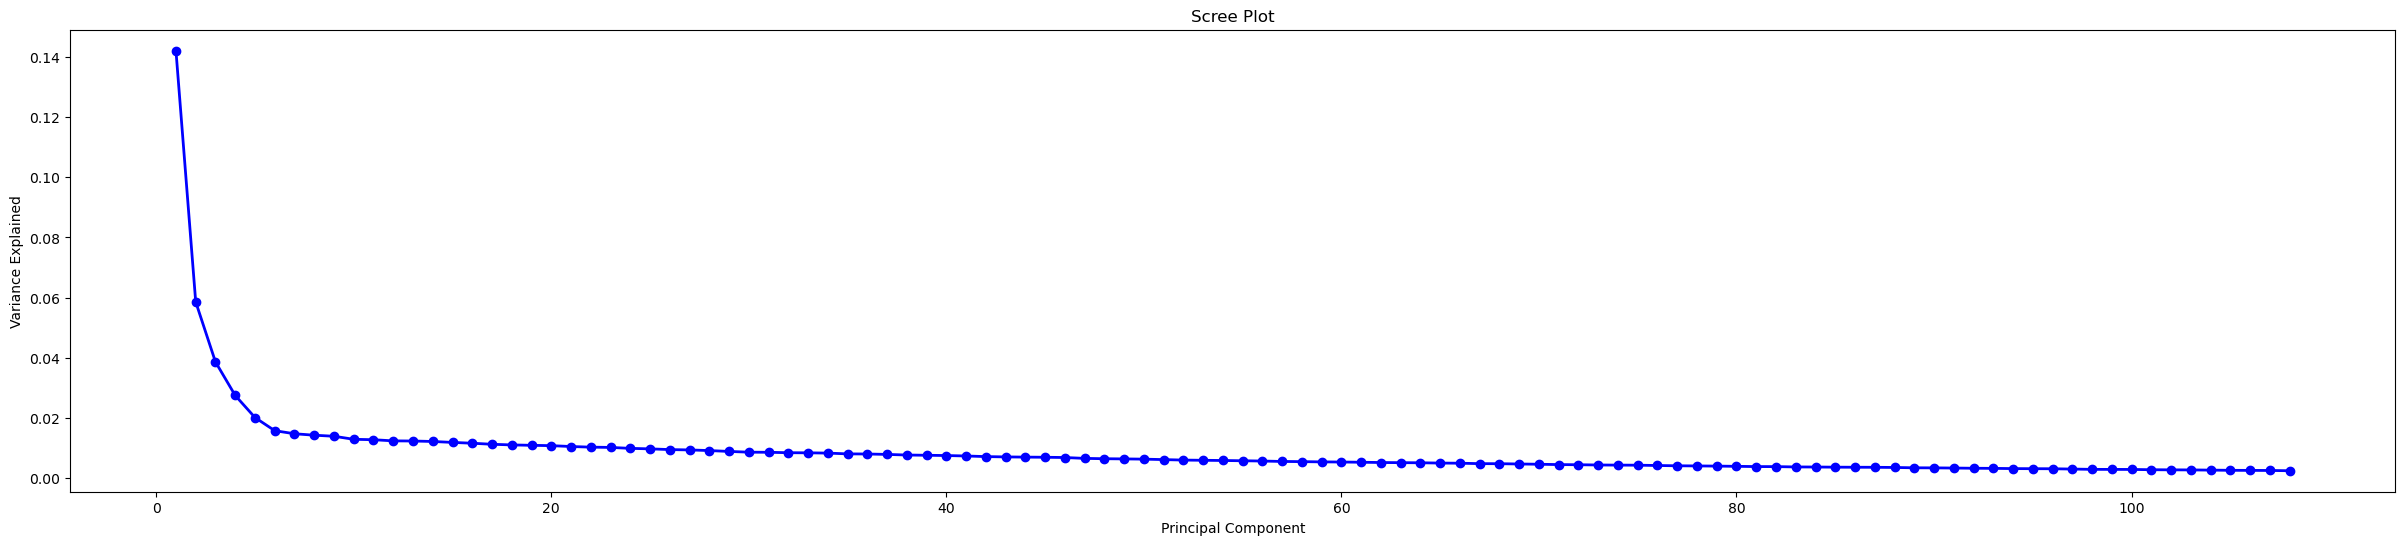

In [429]:
scaler = MinMaxScaler()
data_pca=dp.T
data_rescaled = scaler.fit_transform(data_pca)
pca = PCA(n_components=0.95).fit(data_rescaled)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

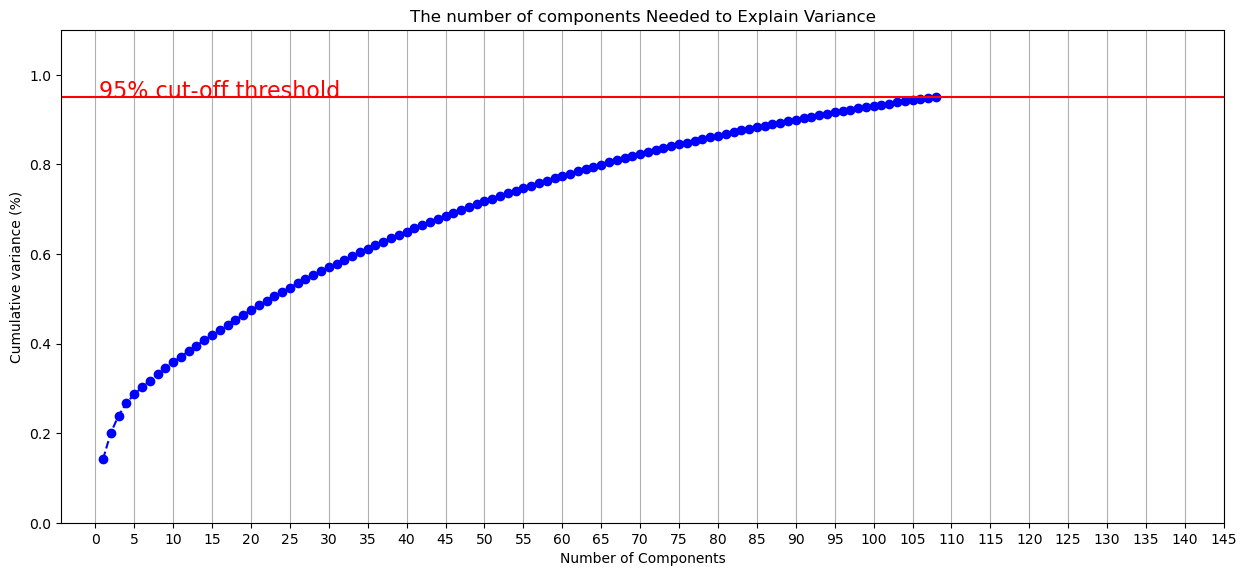

In [430]:
# % matplotlib inline
#plt.rcParams["figure.figsize"] = (30,6)
#plt.figure()
fig, ax = plt.subplots(figsize=(15,6.4))
xi = np.arange(pca.n_components_) + 1
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 150, step=5)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components Needed to Explain Variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.95, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [431]:
dp_pca=pca.fit_transform(data_rescaled)

In [432]:
dp_pca.shape

(179, 108)

In [439]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import statistics
clf = svm.SVC(kernel='rbf') 
cv = ShuffleSplit(n_splits=21, test_size=0.3, random_state=2)
l=cross_val_score(clf, dp_pca,label, cv=cv)
statistics.median(l)

0.6296296296296297

In [440]:
#cv.get_n_splits(dp_pca)
idx=np.where(l==statistics.median(l))[0][0]

In [441]:
train=[]
test=[]
for i, (train_index, test_index) in enumerate(cv.split(dp_pca)):
    train.append(train_index)
    test.append(test_index)
x_train=dp_pca[train[idx]]
y_train=label[train[idx]]
y_test=label[test[idx]]
x_test=dp_pca[test[idx]]
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6296296296296297


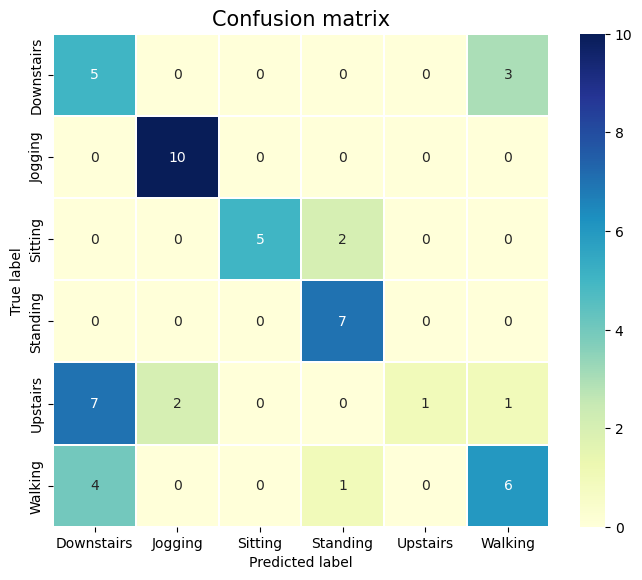

In [442]:
from sklearn.metrics import confusion_matrix
#plt.rcParams["figure.figsize"] = (30,6)
plt.figure(figsize=(8,6.4))
labels = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = "YlGnBu")
plt.title("KF+SVM Confusion matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

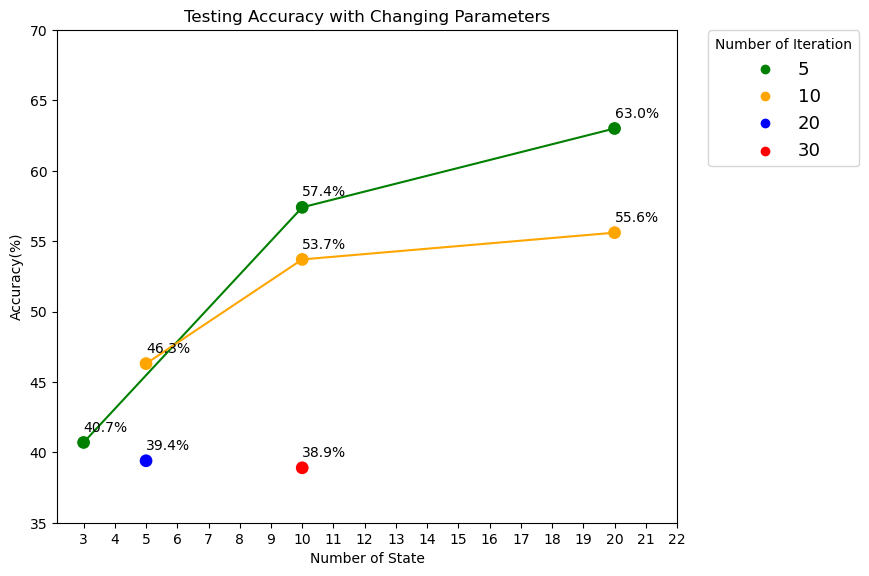

In [450]:

iteration=np.array([5,5,5,10,10,10,20,30])
state=np.array([3,10,20,5,10,20,5,10])
accuracy=np.array([40.7,57.4,63.0,46.3,53.7,55.6,39.4,38.9])
plt.figure(figsize=(8,6.4))
# fig, ax = plt.subplots(figsize=(8,6.4))
sns.lineplot(x=state,y=accuracy,hue=iteration,palette=['green','orange','blue','red'], legend='full')#,s=100,ax=ax

g=sns.scatterplot(x=state,y=accuracy,hue=iteration,palette=['green','orange','blue','red'], legend='full',s=100)#,ax=ax
plt.xlabel("Number of State")
plt.ylabel("Accuracy(%)")
plt.ylim(35,70)
h,l = g.get_legend_handles_labels()
plt.legend(list(h[i] for i in [4,5,6,7]),list(l[i] for i in [4,5,6,7]),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13,title="Number of Iteration")
# handles, labels = ax.get_legend_handles_labels()
# ax.legend([tuple(handles[::4]), tuple(handles[1::4])], labels[:4], handlelength=4,
#           handler_map={tuple: HandlerTuple(ndivide=None)})
plt.title("Testing Accuracy with Changing Parameters")
plt.xticks(np.arange(min(state), max(state)+3, 1))
acc_percentage=["40.7%","57.4%","63.0%","46.3%","53.7%","55.6%","39.4%","38.9%"]
for i, acc in enumerate (acc_percentage):
    plt.annotate(acc, (state[i], accuracy[i]+0.8) )